In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import copy
import os
import deap

# --- Importaciones para GA ---

from deap import base, creator, tools, algorithms
from myutils.dataloader import cargar_todo_el_sistema
from arch.genetic_optimizer import OptimizadorHorarios
from src.graficar_horarios import plot_horario_plotly, plot_horario_interactivo



# --- Importaciones para ACO (Milagrito) ---    
from myutils.datos_horarios import TimetablingData
from arch.evaluacion_horarios import TimetablingEvaluator
from arch.aco_horarios import ACOTimetabler


# Configuración visual
%matplotlib inline
plt.style.use('ggplot')
print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [2]:
# 1. Cargar datos para el GA
datos_ga = cargar_todo_el_sistema()
SEED = 1          # o el número que quieras
random.seed(SEED)      # Semilla global de python
np.random.seed(SEED)   # Semilla global de numpy
print(f"Semilla fija establecida: {SEED}")

# 2. Instanciar clase Optimizador (

optimizer = OptimizadorHorarios(datos_ga, seed=SEED)

# 3. Configurar DEAP
if hasattr(creator, "FitnessMax"):
    del creator.FitnessMax
if hasattr(creator, "Individual"):
    del creator.Individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", dict, fitness=creator.FitnessMax)
toolbox = base.Toolbox()

# Creación de individuos
toolbox.register("crear_horario_dict", optimizer.crear_individuo)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.crear_horario_dict)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("clone", copy.deepcopy)

# Evaluación
toolbox.register("evaluate", lambda ind: (optimizer.evaluar_horario(ind)[0], ))

# Operadores Genéticos
toolbox.register("mutate", optimizer.mutar_horario) 
toolbox.register("mate", optimizer.crossover_horarios)

# Selección (se mantiene igual)
toolbox.register("select", tools.selTournament, tournsize=6)

print(f"Configuración del GA completada con semilla fija (SEED={SEED}).")

--- Iniciando Dataloader ---
Datos cargados: 11 asig, 8 tipos aula, 14 clases, 23 profes.
Total de tareas (horas lectivas) a programar: 448
--- Dataloader Finalizado Correctamente ---
Semilla fija establecida: 1
Configuración del GA completada con semilla fija (SEED=1).


In [3]:
from src.factible import es_factible
#cargamos el horario para poder meterlo en el aco
def cargar_horario_desde_csv(filepath):
    df = pd.read_csv(filepath)
    horario = {}
    
    for _, row in df.iterrows():
        task_id = row["Task_ID"]
        profesor = row["Professor"]
        dia = row["Day"]
        periodo = row["Period"]
        aula = row["Room"]
        
        horario[task_id] = (profesor, (dia, periodo), aula)
    
    return horario

horario_factible = cargar_horario_desde_csv("horario_factible.csv")

sol_inicial_aco = dict(horario_factible)  # Convertir DEAP Individual a dict

# 1. Cargar datos usando la clase específica de ACO (como en Milagrito)
data_aco = TimetablingData.from_csv_folder(data_folder="data")

# 2. Crear evaluador
evaluator_aco = TimetablingEvaluator(data_aco, H_ideal=1, Us=3)
sol_inicial_aco = dict(horario_factible)  # Convertir DEAP Individual a dict
solucio_ga=sol_inicial_aco.copy()
# 4. Calcular coste inicial
coste_inicial = evaluator_aco.cost(sol_inicial_aco)
print(f"Coste inicial (Salida GA): {coste_inicial:.3f}")

# 5. Instanciar el optimizador
aco = ACOTimetabler(data_aco, evaluator_aco)

Coste inicial (Salida GA): 22820.572


In [4]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
import pickle
import os


class NeuroOptimizador:
    def __init__(
        self,
        datos,
        aco_helper,
        evaluator,
        validador_factible,
        ruta_pesos="pesos_neuroopt.pkl",
        cargar_pesos=False,
        batch_size=32,
        max_memory=300,
        mlp_params=None
    ):
        """
        datos: diccionario con, al menos:
            - 'tasks_df'
            - 'rooms_df'
            - 'days'
            - 'prof_subject', 'prof_max_hours', 'valid_rooms',
              'Hmax_subject_day', 'Hmax_prof_day' (para es_factible)
        evaluator: objeto/función con método .cost(sol)
        validador_factible: es_factible(sol, tasks_df, prof_subject, prof_max_hours,
                                         valid_rooms, rooms_df, Hmax_subject_day, Hmax_prof_day)
        """
        default_mlp_params = dict(
            hidden_layer_sizes=(64, 32),
            activation='relu',
            solver='adam',
            learning_rate_init=0.01,
            alpha=0.0001,
            random_state=42
        )
        if mlp_params is not None:
            default_mlp_params.update(mlp_params)
        self.datos = datos
        self.aco = aco_helper
        self.evaluator = evaluator
        self.es_factible_fn = validador_factible



        # --- CEREBRO: Perceptrón Multicapa ---
        self.model = MLPRegressor(**default_mlp_params)
        self.scaler = StandardScaler()
        self.is_fitted = False

        # Memoria de experiencias
        self.memory = []
        self.batch_size = batch_size
        self.max_memory = max_memory

        # Mejor solución factible conocida
        self.mejor_sol_factible = None
        self.mejor_coste_factible = np.inf

        # Gestión de pesos
        self.ruta_pesos = ruta_pesos
        if cargar_pesos and os.path.exists(self.ruta_pesos):
            self._cargar_pesos()

    # ==========================================================
    #  Conversión de solución a DataFrame de contexto
    # ==========================================================
    def _convertir_sol_a_df(self, sol):
        """
        sol: dict {task_id: (prof, (day, period), room)}
        -> DataFrame con columnas:
        ['task_id','professor','group','day','period','room','planta']
        """
        rows = []
        tasks_df = self.datos['tasks_df']
        rooms_df = self.datos['rooms_df']

        for task_id, (p, (d, h), r) in sol.items():
            grupo = tasks_df.loc[task_id, 'group'] if 'group' in tasks_df.columns else None
            planta = rooms_df.loc[r, 'planta'] if r in rooms_df.index and 'planta' in rooms_df.columns else 0

            rows.append({
                'task_id': task_id,
                'professor': p,
                'group': grupo,
                'day': d,
                'period': h,
                'room': r,
                'planta': planta
            })

        df = pd.DataFrame(rows)
        return df

    # ==========================================================
    #  Función maestra de features (C1–C18)
    # ==========================================================
    def _extraer_features_complejas(self, sol, task_id, df_contexto=None):
        """
        Vector numérico que representa el estado de esa tarea (basado en C1–C18).
        """
        # Estado de la tarea
        p, (d, h), r = sol[task_id]

        # Contexto global
        if df_contexto is None:
            df_contexto = self._convertir_sol_a_df(sol)

        tasks_df = self.datos['tasks_df']
        rooms_df = self.datos['rooms_df']

        # Clases del profesor / grupo ese día
        classes_prof_day = df_contexto[
            (df_contexto['professor'] == p) &
            (df_contexto['day'] == d)
        ]

        grupo_tarea = tasks_df.loc[task_id, 'group'] if 'group' in tasks_df.columns else None
        if grupo_tarea is not None:
            classes_group_day = df_contexto[
                (df_contexto['group'] == grupo_tarea) &
                (df_contexto['day'] == d)
            ]
        else:
            classes_group_day = pd.DataFrame(columns=df_contexto.columns)

        features = []

        # [Time Info] Normalizados
        days_list = self.datos['days']
        d_idx = days_list.index(d) if d in days_list else 0
        features.append(d_idx / max(len(days_list), 1))  # Día normalizado
        features.append(h / 10.0)                        # Hora normalizada (asumiendo 1–10)

        # [C1] Preferencia mañana vs tarde
        features.append(1.0 if h <= 5 else 0.0)

        # [C2 & C4] Huecos PROFESOR
        periods_prof = set(classes_prof_day['period'])
        is_isolated_prof = (
            (h - 1 not in periods_prof) and
            (h + 1 not in periods_prof) and
            (len(periods_prof) > 1)
        )
        features.append(1.0 if is_isolated_prof else 0.0)

        # Huecos GRUPO (opcional)
        periods_group = set(classes_group_day['period'])
        is_isolated_group = (
            (h - 1 not in periods_group) and
            (h + 1 not in periods_group) and
            (len(periods_group) > 1)
        )
        features.append(1.0 if is_isolated_group else 0.0)

        # [C5] Carga total del profesor
        carga_prof = len(df_contexto[df_contexto['professor'] == p])
        features.append(carga_prof / 20.0)  # normalización aproximada

        # [C8 & C14] Coherencia de planta (profesor)
        planta_actual = rooms_df.loc[r, 'planta'] if r in rooms_df.index and 'planta' in rooms_df.columns else 0
        plantas_prof = classes_prof_day['planta'].unique()
        mezcla_plantas = 1.0 if len(plantas_prof) > 1 else 0.0
        if len(plantas_prof) > 0:
            moda_planta = pd.Series(plantas_prof).mode()[0]
            planta_distinta = 1.0 if planta_actual != moda_planta else 0.0
        else:
            planta_distinta = 0.0
        features.append(mezcla_plantas)
        features.append(planta_distinta)

        # [C11] Tardes aisladas
        is_afternoon = h > 5
        count_afternoon = classes_prof_day[classes_prof_day['period'] > 5].shape[0]
        features.append(1.0 if is_afternoon and count_afternoon == 1 else 0.0)

        # [C12 & C13] Carga diaria profe y grupo
        load_day_prof = len(classes_prof_day)
        load_day_group = len(classes_group_day)
        features.append(load_day_prof / 8.0)   # normalización aprox.
        features.append(load_day_group / 8.0)

        # [C15] Franjas malas
        bad_slots = [6, 7, 8, 9, 10]
        features.append(1.0 if h in bad_slots else 0.0)

        # [C18] Saturación del aula
        room_usage = len(df_contexto[df_contexto['room'] == r])
        features.append(room_usage / 40.0)  # normalización aprox.

        return np.array(features, dtype=float)

    def _extraer_features_tarea(self, sol, task_id, df_contexto=None):
        """Wrapper para mantener el nombre 'oficial'."""
        return self._extraer_features_complejas(sol, task_id, df_contexto=df_contexto)

    # ==========================================================
    #  Memoria y entrenamiento de la red
    # ==========================================================
    def registrar_experiencia(self, sol, task_id, target):
        """
        target = recompensa / valor que quieres que aprenda el MLP.
        """
        experiencia = (deepcopy(sol), task_id, float(target))
        self.memory.append(experiencia)
        if len(self.memory) > self.max_memory:
            self.memory = self.memory[-self.max_memory:]

    def _preparar_batch_red(self, experiencias):
        X, y = [], []
        for sol, task_id, target in experiencias:
            df_contexto = self._convertir_sol_a_df(sol)
            feats = self._extraer_features_tarea(sol, task_id, df_contexto=df_contexto)
            X.append(feats)
            y.append(target)
        X = np.array(X, dtype=float)
        y = np.array(y, dtype=float)
        return X, y

    def _actualizar_red(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        X, y = self._preparar_batch_red(batch)

        if not self.is_fitted:
            self.scaler.fit(X)
            X_scaled = self.scaler.transform(X)
            self.model.partial_fit(X_scaled, y)
            self.is_fitted = True
        else:
            X_scaled = self.scaler.transform(X)
            self.model.partial_fit(X_scaled, y)

    # ==========================================================
    #  Predicción de calidad
    # ==========================================================
    def predecir_calidad_tarea(self, sol, task_id):
        df_contexto = self._convertir_sol_a_df(sol)
        x = self._extraer_features_tarea(sol, task_id, df_contexto=df_contexto).reshape(1, -1)

        if not self.is_fitted:
            return 0.0

        x_scaled = self.scaler.transform(x)
        pred = self.model.predict(x_scaled)[0]
        return float(pred)

    # ==========================================================
    #  Factibilidad (wrapper) — aquí se arregla lo del 83
    # ==========================================================
    def _es_factible(self, sol):
        """
        Usa es_factible(...) pero interpretando correctamente:
        - bool  -> se respeta
        - int   -> 0 = factible, >0 = no factible
        - dict  -> si trae 'total_violations', se usa
        """
        res = self.es_factible_fn(
            sol,
            self.datos['tasks_df'],
            self.datos['prof_subject'],
            self.datos['prof_max_hours'],
            self.datos['valid_rooms'],
            self.datos['rooms_df'],
            self.datos['Hmax_subject_day'],
            self.datos['Hmax_prof_day']
        )

        # Caso 1: ya es booleano
        if isinstance(res, bool):
            return res

        # Caso 2: entero = nº de violaciones
        if isinstance(res, (int, np.integer)):
            return (res == 0)

        # Caso 3: dict con info
        if isinstance(res, dict):
            if 'total_violations' in res:
                return (res['total_violations'] == 0)

        # Fallback
        return bool(res)

    # ==========================================================
    #  Gestión de mejor solución factible global
    # ==========================================================
    def _actualizar_mejor_factible(self, sol, coste=None):
        """
        Si 'sol' es factible y mejora el coste, actualiza el mejor conocido.
        """
        if not self._es_factible(sol):
            return

        if coste is None:
            coste = self.evaluator.cost(sol)

        if coste < self.mejor_coste_factible:
            self.mejor_coste_factible = coste
            self.mejor_sol_factible = deepcopy(sol)

    def get_mejor_solucion_factible(self):
        """
        Devuelve la mejor solución factible conocida (o None si no hay).
        """
        return deepcopy(self.mejor_sol_factible)

    # ==========================================================
    #  Movimiento local guiado por la red
    # ==========================================================
    def _vecino_basico(self, sol, task_id):
        """
        Genera un vecino modificando día, hora y aula de una tarea,
        respetando las aulas válidas definidas en datos['valid_rooms'].
        """
        new_sol = deepcopy(sol)
        p, (d, h), r = new_sol[task_id]

        days = self.datos['days']
        rooms_ids = list(self.datos['rooms_df'].index)

        # Horas: asumimos 1..10 si no hay info
        max_period = 10
        if 'max_period' in self.datos:
            max_period = int(self.datos['max_period'])

        # Aulas válidas para esta tarea (si existen)
        if 'valid_rooms' in self.datos and task_id in self.datos['valid_rooms']:
            rooms_valid = list(self.datos['valid_rooms'][task_id])
            if len(rooms_valid) == 0:
                rooms_valid = rooms_ids
        else:
            rooms_valid = rooms_ids

        new_d = random.choice(days)
        new_h = random.randint(1, max_period)
        new_r = random.choice(rooms_valid)

        new_sol[task_id] = (p, (new_d, new_h), new_r)
        return new_sol

    def entrenar_paso(self, sol_actual, n_intentos=20, exploracion=0.3):
        """
        Un paso de búsqueda local:
        - Explora vecinos de sol_actual.
        - Actualiza SIEMPRE la mejor solución factible global.
        - Devuelve SIEMPRE la mejor solución factible conocida (si existe).
        """
        coste_actual = self.evaluator.cost(sol_actual)

        # Actualizamos mejor factible con la solución actual (si lo es)
        self._actualizar_mejor_factible(sol_actual, coste=coste_actual)

        tasks_ids = list(self.datos['tasks_df'].index)

        for _ in range(n_intentos):
            # 1) Elegir tarea a mover
            if self.is_fitted and random.random() > exploracion:
                # Exploit: elegir la peor según la red entre una muestra pequeña
                muestra = random.sample(tasks_ids, min(10, len(tasks_ids)))
                pred_scores = []
                for t_id in muestra:
                    score = self.predecir_calidad_tarea(sol_actual, t_id)
                    pred_scores.append((score, t_id))
                # Suponemos que score alto = peor (ajusta si decides lo contrario)
                _, task_id = max(pred_scores, key=lambda x: x[0])
            else:
                # Explore: tarea al azar
                task_id = random.choice(tasks_ids)

            # 2) Generar vecino
            candidato = self._vecino_basico(sol_actual, task_id)

            # 3) Comprobar factibilidad del vecino (ya usando el fix de 0/83)
            if not self._es_factible(candidato):
                # Penalizamos ese movimiento en la memoria (reward negativo)
                self.registrar_experiencia(sol_actual, task_id, target=-1.0)
                continue

            # 4) Calcular coste del vecino factible
            coste_candidato = self.evaluator.cost(candidato)

            # Reward = mejora respecto a sol_actual (puedes cambiar a respecto a mejor_factible si quieres)
            reward = coste_actual - coste_candidato
            self.registrar_experiencia(sol_actual, task_id, target=reward)

            # 5) Actualizar mejor factible global
            self._actualizar_mejor_factible(candidato, coste=coste_candidato)

        # 6) Actualizar la red tras este paso
        self._actualizar_red()

        # 7) Devolver SIEMPRE la mejor factible conocida (si la hay)
        if self.mejor_sol_factible is not None:
            return deepcopy(self.mejor_sol_factible), self.mejor_coste_factible
        else:
            # No se ha encontrado ninguna solución factible todavía
            print("[NeuroOpt] WARNING: aún no se ha encontrado ninguna solución factible. Devuelvo sol_actual tal cual.")
            return sol_actual, coste_actual

    # ==========================================================
    #  Gestión de pesos (guardar / cargar)
    # ==========================================================
    def _guardar_pesos(self):
        payload = {
            'model': self.model,
            'scaler': self.scaler,
            'is_fitted': self.is_fitted
        }
        with open(self.ruta_pesos, 'wb') as f:
            pickle.dump(payload, f)

    def _cargar_pesos(self):
        with open(self.ruta_pesos, 'rb') as f:
            payload = pickle.load(f)
        self.model = payload['model']
        self.scaler = payload['scaler']
        self.is_fitted = payload['is_fitted']

    # Métodos públicos para que tu script los use
    def guardar_cerebro(self, ruta=None):
        if ruta is not None:
            self.ruta_pesos = ruta
        self._guardar_pesos()

    def cargar_cerebro(self, ruta=None):
        if ruta is not None:
            self.ruta_pesos = ruta
        if os.path.exists(self.ruta_pesos):
            self._cargar_pesos()
        else:
            print(f"[NeuroOpt] No se encontró el fichero de pesos: {self.ruta_pesos}")


In [5]:
def evaluar_config_neuro(mlp_params, 
                         datos_ga, aco, evaluator_aco, es_factible,
                         solucion_ga, 
                         n_iters=200, 
                         seed=0,
                         devolver_historia=False):
    random.seed(seed)
    np.random.seed(seed)
    
    # 1. Instanciar el optimizador con estos hiperparámetros
    neuro = NeuroOptimizador(
        datos_ga, aco, evaluator_aco, es_factible, 
        mlp_params=mlp_params
    )
    
    # 2. Partimos de la solución del GA
    current_sol = solucion_ga.copy()
    current_cost = evaluator_aco.cost(current_sol)
    
    # Historial de costes (inicial incluido)
    history_costs = [current_cost]
    
    # 3. Ejecutamos n_iters pasos
    for i in range(n_iters):
        current_sol, current_cost = neuro.entrenar_paso(current_sol)
        history_costs.append(current_cost)
    
    # 4. Medir factibilidad
    res = es_factible(
        current_sol,
        datos_ga['tasks_df'],
        datos_ga['prof_subject'],
        datos_ga['prof_max_hours'],
        datos_ga['valid_rooms'],
        datos_ga['rooms_df'],
        datos_ga['Hmax_subject_day'],
        datos_ga['Hmax_prof_day']
    )
    if res is True:
        violaciones = 0
    else:
        violaciones = int(res)
    
    # 5. Definir un score combinando coste y violaciones
    score = current_cost + 1000 * violaciones
    
    if devolver_historia:
        return score, current_cost, violaciones, current_sol, history_costs
    else:
        return score, current_cost, violaciones, current_sol



=== Config 1/5: {'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.001, 'alpha': 0.0001} ===
Score: 22521.919 | Coste final: 22521.919 | Violaciones: 0

=== Config 2/5: {'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001, 'alpha': 0.0001} ===
Score: 22446.323 | Coste final: 22446.323 | Violaciones: 0

=== Config 3/5: {'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.0005, 'alpha': 0.0001} ===
Score: 22593.512 | Coste final: 22593.512 | Violaciones: 0

=== Config 4/5: {'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001, 'alpha': 0.001} ===
Score: 22671.602 | Coste final: 22671.602 | Violaciones: 0

=== Config 5/5: {'hidden_layer_sizes': (256, 128), 'learning_rate_init': 0.001, 'alpha': 0.0001} ===
Score: 22207.817 | Coste final: 22207.817 | Violaciones: 0


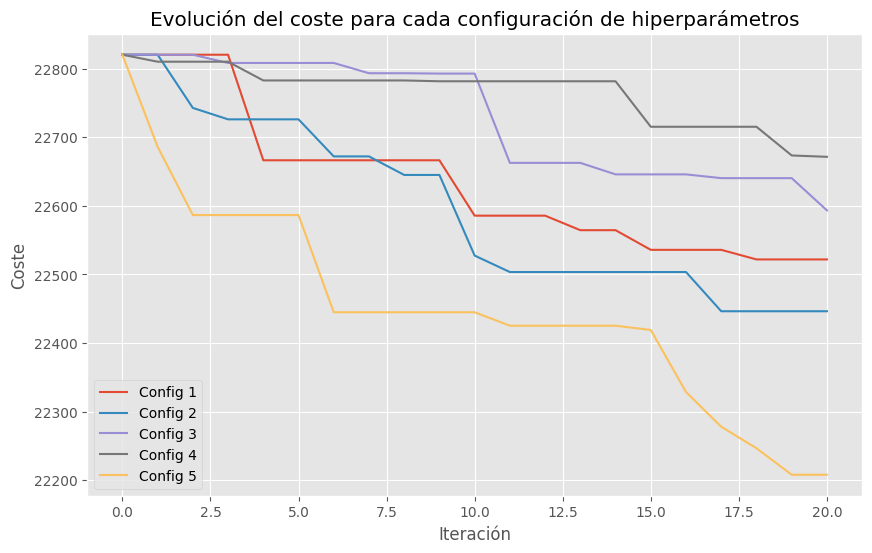

In [8]:
config_space = [
    {"hidden_layer_sizes": (64, 32), "learning_rate_init": 0.001, "alpha": 0.0001},
    {"hidden_layer_sizes": (128, 64), "learning_rate_init": 0.001, "alpha": 0.0001},
    {"hidden_layer_sizes": (128, 64), "learning_rate_init": 0.0005, "alpha": 0.0001},
    {"hidden_layer_sizes": (128, 64), "learning_rate_init": 0.001, "alpha": 0.001},
    {"hidden_layer_sizes": (256, 128), "learning_rate_init": 0.001, "alpha": 0.0001},
]

mejor_score = float("inf")
mejor_conf = None
mejor_sol = None

import matplotlib.pyplot as plt

resultados = []
historias = []

for i, conf in enumerate(config_space, start=1):
    print(f"\n=== Config {i}/{len(config_space)}: {conf} ===")
    
    score, cost_final, viol, sol_final, hist = evaluar_config_neuro(
        conf,
        datos_ga, aco, evaluator_aco, es_factible,
        solucio_ga,
        n_iters=20,
        seed=123 + i,          # cambias la semilla para cada config si quieres
        devolver_historia=True
    )
    
    resultados.append((conf, score, cost_final, viol, sol_final))
    historias.append((f"Config {i}", hist))
    
    print(f"Score: {score:.3f} | Coste final: {cost_final:.3f} | Violaciones: {viol}")

# --- SOLO SI TÚ QUIERES PLOT ---
hacer_plot = True   # aquí decides tú

if hacer_plot:
    plt.figure(figsize=(10, 6))
    for label, hist in historias:
        plt.plot(hist, label=label)
    plt.xlabel("Iteración")
    plt.ylabel("Coste")
    plt.title("Evolución del coste para cada configuración de hiperparámetros")
    plt.legend()
    plt.grid(True)
    plt.show()




🚀 Iniciando 10 ejecuciones de 100 iteraciones cada una...
  > Ejecución 1/10... Terminada en 70.56s | Coste final: 21401.08
  > Ejecución 2/10... Terminada en 69.85s | Coste final: 21361.64
  > Ejecución 3/10... Terminada en 71.10s | Coste final: 21799.55
  > Ejecución 4/10... Terminada en 69.52s | Coste final: 21579.10
  > Ejecución 5/10... Terminada en 68.65s | Coste final: 21443.28
  > Ejecución 6/10... Terminada en 70.03s | Coste final: 20921.13
  > Ejecución 7/10... Terminada en 70.48s | Coste final: 21816.41
  > Ejecución 8/10... Terminada en 70.10s | Coste final: 21283.37
  > Ejecución 9/10... Terminada en 70.82s | Coste final: 21758.33
  > Ejecución 10/10... Terminada en 69.96s | Coste final: 21289.73

✅ Total completado en 701.07s


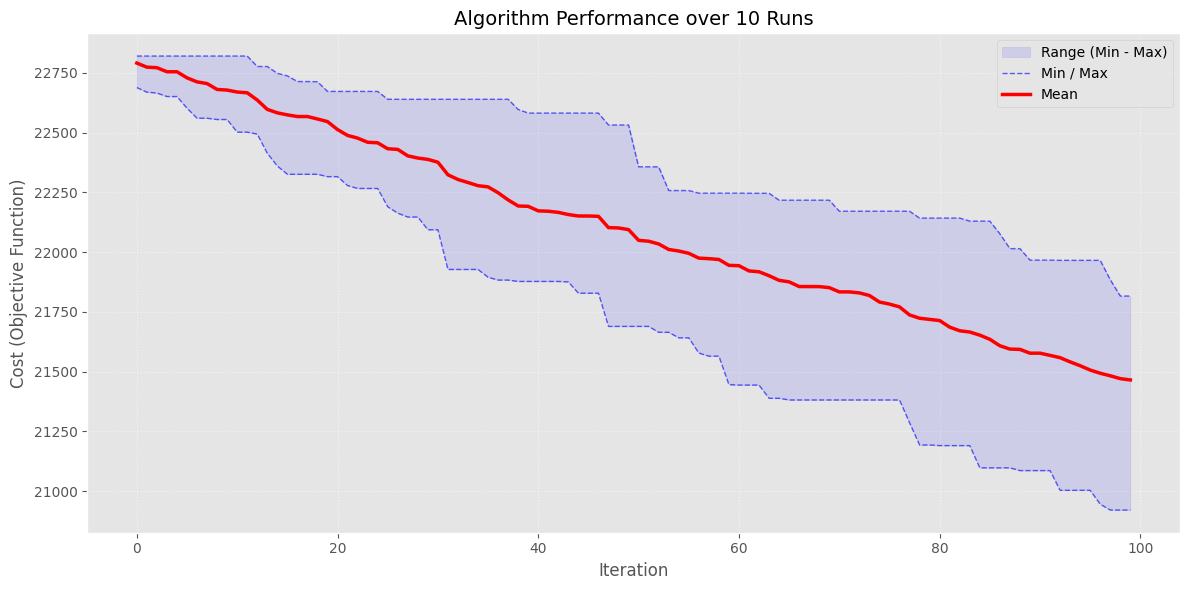

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import time

# --- CONFIGURACIÓN ---
N_RUNS = 10          # Número de ejecuciones independientes
N_ITERS = 100        # Número de iteraciones por ejecución (ajusta según necesites)
all_histories = []   # Para guardar el historial de costes de cada ejecución

mejor_conf = {
    "hidden_layer_sizes": (128, 64),
    "learning_rate_init": 0.01,
    "alpha": 0.0001,
}

print(f"🚀 Iniciando {N_RUNS} ejecuciones de {N_ITERS} iteraciones cada una...")
start_time_total = time.time()

for run in range(N_RUNS):
    print(f"  > Ejecución {run + 1}/{N_RUNS}...", end="")
    run_start = time.time()
    SEED = 42 + run  # Diferente semilla por ejecución
    random.seed(SEED)
    np.random.seed(SEED)
    
    # 1. Instanciar un NUEVO optimizador en cada vuelta (para reiniciar el cerebro/MLP)
    # Se usan los mismos datos y validadores que ya tienes cargados
    neuro_opt_temp = NeuroOptimizador(
        datos=datos_ga, 
        aco_helper=aco, 
        evaluator=evaluator_aco,
        validador_factible=es_factible,
        mlp_params= mejor_conf
    )
    
    # 2. Partir siempre de la misma solución inicial (la del GA)
    # Convertimos a dict por si viene de DEAP
    if hasattr(solucio_ga, "fitness"): # Es un individuo DEAP
        current_sol = dict(solucio_ga)
    else:
        current_sol = copy.deepcopy(solucio_ga)
        
    history = []
    
    # 3. Bucle de optimización (Iteraciones)
    for i in range(N_ITERS):
        # Ejecutamos un paso de entrenamiento/mejora
        # Nota: entrenar_paso devuelve la mejor solución factible encontrada hasta el momento
        best_sol, current_cost = neuro_opt_temp.entrenar_paso(current_sol)
        
        # Guardamos el coste actual
        history.append(current_cost)
        
        # Actualizamos la solución actual para la siguiente iteración
        # (Esto permite al algoritmo seguir explorando desde el mejor punto encontrado)
        current_sol = best_sol
    
    # Guardamos el historial de esta ejecución
    all_histories.append(history)
    print(f" Terminada en {time.time() - run_start:.2f}s | Coste final: {history[-1]:.2f}")

print(f"\n✅ Total completado en {time.time() - start_time_total:.2f}s")

# --- PROCESAMIENTO DE DATOS ---
# Convertimos a matriz numpy para facilitar cálculos: [filas=runs, col=iters]
data = np.array(all_histories)

# Calculamos estadísticas por columna (por cada iteración)
mean_costs = np.mean(data, axis=0) # Media
min_costs = np.min(data, axis=0)   # Mínimo
max_costs = np.max(data, axis=0)   # Máximo
iterations = np.arange(N_ITERS)

# --- GRÁFICA ---
plt.figure(figsize=(12, 6))

# Relleno entre min y max (zona de varianza)
plt.fill_between(iterations, min_costs, max_costs, color='blue', alpha=0.1, label='Range (Min - Max)')

# Líneas de mínimo y máximo (azules)
plt.plot(iterations, min_costs, color='blue', linestyle='--', linewidth=1, alpha=0.6, label='Min / Max')
plt.plot(iterations, max_costs, color='blue', linestyle='--', linewidth=1, alpha=0.6)

# Línea de la media (roja)
plt.plot(iterations, mean_costs, color='red', linewidth=2.5, label='Mean')
# Detalles del gráfico
plt.title(f'Algorithm Performance over {N_RUNS} Runs', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cost (Objective Function)', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

--- Iniciando Neuro-Optimización ---
Coste Inicial: 22820.572
Iter 0: Coste 22820.572 | Tiempo: 0.2s | Memoria: 20
Iter 10: Coste 22794.339 | Tiempo: 6.7s | Memoria: 220
Iter 20: Coste 22522.282 | Tiempo: 13.8s | Memoria: 300
Iter 30: Coste 22306.579 | Tiempo: 20.9s | Memoria: 300
Iter 40: Coste 21953.352 | Tiempo: 28.2s | Memoria: 300
Iter 50: Coste 21831.412 | Tiempo: 35.1s | Memoria: 300
Iter 60: Coste 21794.697 | Tiempo: 41.9s | Memoria: 300
Iter 70: Coste 21553.252 | Tiempo: 49.1s | Memoria: 300
Iter 80: Coste 21536.210 | Tiempo: 56.3s | Memoria: 300
Iter 90: Coste 21521.692 | Tiempo: 63.6s | Memoria: 300
Iter 100: Coste 21401.080 | Tiempo: 70.3s | Memoria: 300
Iter 110: Coste 21342.780 | Tiempo: 77.3s | Memoria: 300
Iter 120: Coste 21140.859 | Tiempo: 84.3s | Memoria: 300
Iter 130: Coste 21065.144 | Tiempo: 91.3s | Memoria: 300
Iter 140: Coste 20858.546 | Tiempo: 98.4s | Memoria: 300
Iter 150: Coste 20858.546 | Tiempo: 105.5s | Memoria: 300
Iter 160: Coste 20799.746 | Tiempo: 112

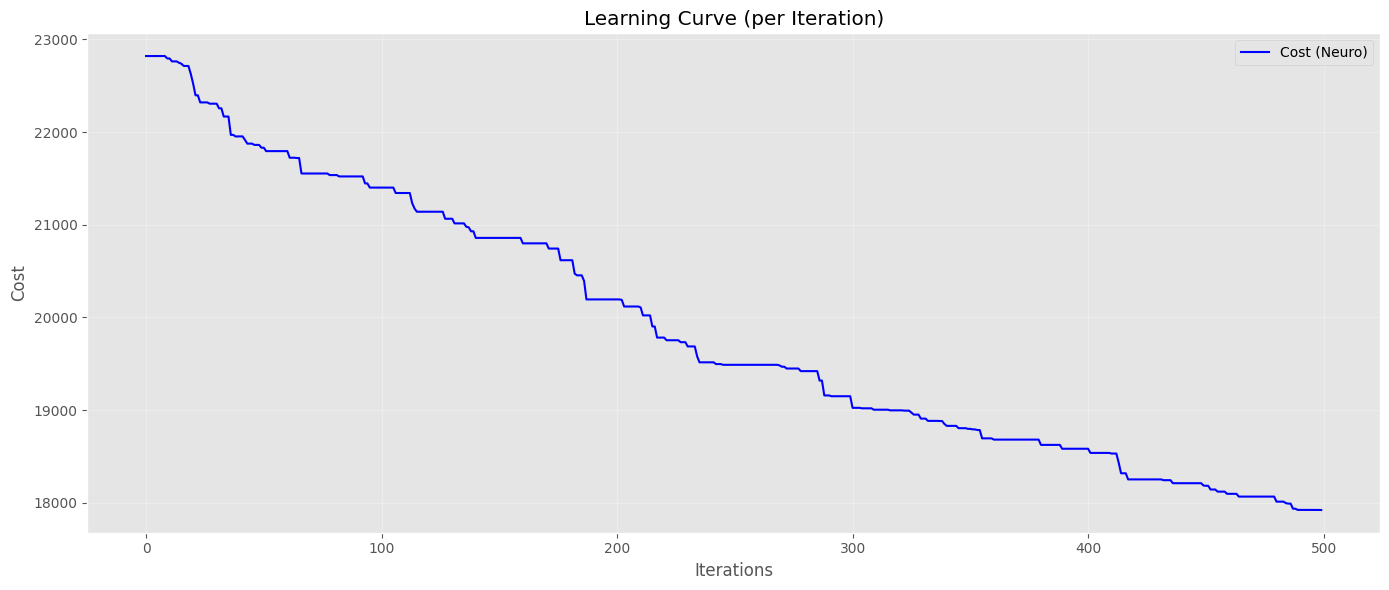

In [6]:
import time
import matplotlib.pyplot as plt

mejor_conf = {
    "hidden_layer_sizes": (128, 64),
    "learning_rate_init": 0.01,
    "alpha": 0.0001,
}

# 1. Instanciar
neuro_opt = NeuroOptimizador(
    datos=datos_ga, 
    aco_helper=aco, 
    evaluator=evaluator_aco,
    validador_factible=es_factible,
    mlp_params=mejor_conf
)

# 2. Intentar cargar un cerebro previo (si existe)
#neuro_opt.cargar_cerebro("Milagro_entre_milagros.pkl")

print("--- Iniciando Neuro-Optimización ---")

# Inicialización
current_sol = solucio_ga.copy() # Empezamos desde la solución del GA
current_cost = evaluator_aco.cost(current_sol)
print(f"Coste Inicial: {current_cost:.3f}")

# Historiales
history_neuro = []
history_time = [] # Nueva lista para guardar el tiempo

ITERACIONES = 500 # Ajusta según paciencia
start_time = time.time() # Marcamos el inicio del reloj

for i in range(ITERACIONES):
    # Ejecuta un paso: la red propone, validamos, ejecutamos y la red aprende
    current_sol, new_c = neuro_opt.entrenar_paso(current_sol, n_intentos=20)
    
    # Registramos datos
    history_neuro.append(new_c)
    
    # Calculamos tiempo transcurrido hasta ahora
    elapsed_time = time.time() - start_time
    history_time.append(elapsed_time)
    
    if i % 10 == 0:
        print(f"Iter {i}: Coste {new_c:.3f} | Tiempo: {elapsed_time:.1f}s | Memoria: {len(neuro_opt.memory)}")

# 3. Al finalizar, guardar lo aprendido
neuro_opt.guardar_cerebro("Milagro_entre_milagros.pkl")

# Guardamos el resultado final de la red
final_neuro_sol = current_sol
print(f"Coste Final Neuro: {new_c:.3f} en {history_time[-1]:.1f} segundos")

# --- GRAFICAR (2 Paneles) ---
plt.figure(figsize=(14, 6))

# Gráfica 1: Coste vs Iteraciones
plt.plot(history_neuro, label="Cost (Neuro)", color='blue')
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Learning Curve (per Iteration)")
plt.grid(True, alpha=0.3)
plt.legend()

# # Gráfica 2: Coste vs Tiempo
# ax2.plot(history_time, history_neuro, label="Coste (Neuro)", color='red')
# ax2.set_xlabel("Tiempo (segundos)")
# ax2.set_ylabel("Coste")
# ax2.set_title("Eficiencia Temporal (Coste vs Tiempo)")
# ax2.grid(True, alpha=0.3)
# ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
from src.factible import es_factible

factibilidad = es_factible(
    current_sol,            # La solución en formato diccionario
    datos_ga['tasks_df'],       # DataFrame de tareas
    datos_ga['prof_subject'],   # Diccionario profe-asignatura
    datos_ga['prof_max_hours'], # Horas máx profe
    datos_ga['valid_rooms'],    # Aulas válidas
    datos_ga['rooms_df'],       # DataFrame de aulas
    datos_ga['Hmax_subject_day'], # Horas máx asignatura/día
    datos_ga['Hmax_prof_day']     # Horas máx profe/día
)
print(f'¿Es factible? {factibilidad}')

#Guardar la solución final en un CSV
def guardar_horario_en_csv(solucion, filepath):
    rows = []
    for task_id, (prof, (dia, hora), aula) in solucion.items():
        rows.append({
            'Task_ID': task_id,
            'Professor': prof,
            'Day': dia,
            'Period': hora,
            'Room': aula
        })
    df = pd.DataFrame(rows)
    df.to_csv(filepath, index=False)
    print(f"Horario guardado en {filepath}")
guardar_horario_en_csv(current_sol, "horario_neuro_opt.csv")

¿Es factible? True
Horario guardado en horario_neuro_opt.csv


✅ Datos externos de Aulas y Clases cargados correctamente.


/tmp/ipykernel_66931/1784761345.py:126: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_load = df_metrics.groupby(['Hora', 'Dia']).size().unstack(fill_value=0)
/tmp/ipykernel_66931/1784761345.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=room_counts.values, y=room_counts.index, palette="viridis", ax=ax2)
/tmp/ipykernel_66931/1784761345.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gaps = df_metrics.groupby(['Profesor', 'Dia']).apply(count_

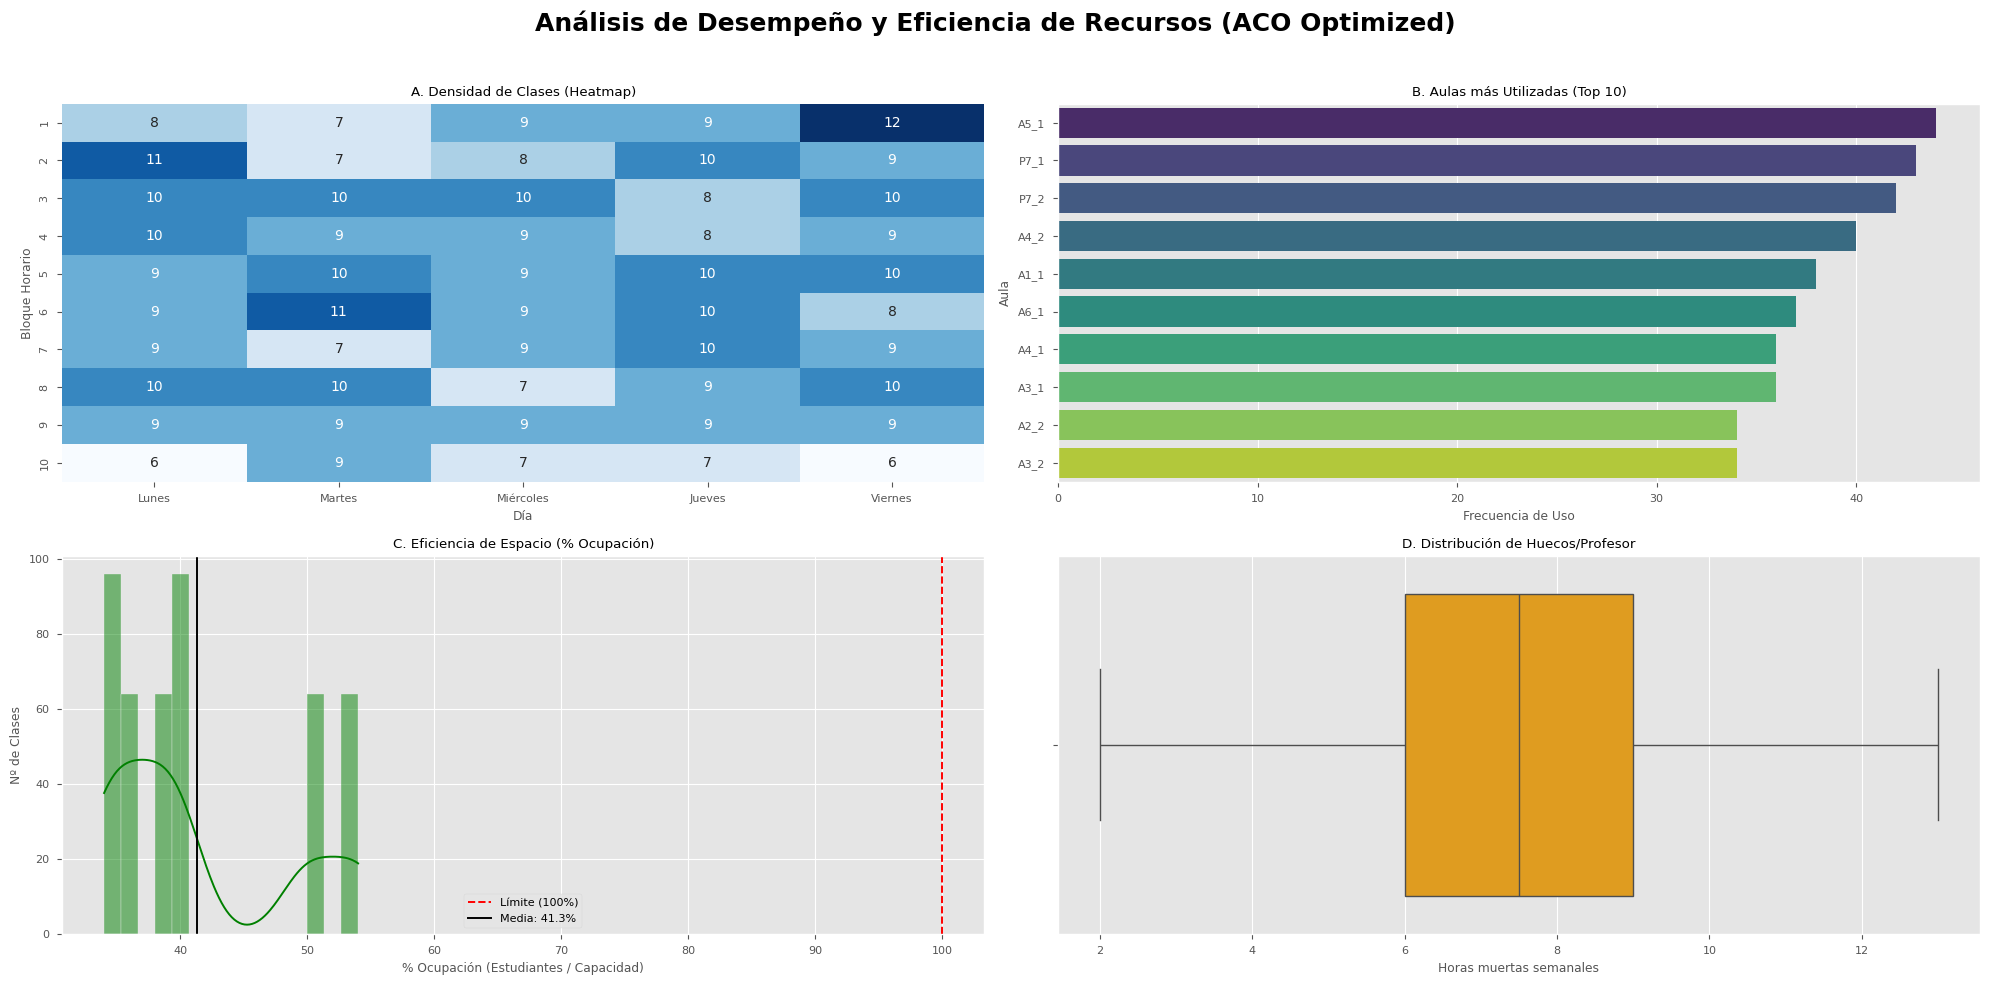

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# ==========================================
# 1. PREPARACIÓN DE DATOS
# ==========================================
best_sol = dict(current_sol)  # Solución final del ACO
def solution_to_dataframe(solucion, data_obj):
    rows = []
    # Estructura sol: task_id -> (prof, (dia, hora), aula)
    for t_id, (prof, (dia, hora), aula) in solucion.items():
        # Info de la tarea original (capacidad, grupo, etc)
        # Asumiendo que data_obj.tasks_df tiene índice o columna TaskID
        if t_id in data_obj.tasks_df.index:
            task_meta = data_obj.tasks_df.loc[t_id]
        else:
            continue # O manejar error
        
        # Recuperar capacidad del aula si existe en data_obj
        cap_aula = 0
        if hasattr(data_obj, 'rooms_df') and aula in data_obj.rooms_df.index:
             cap_aula = data_obj.rooms_df.loc[aula, 'capacity']
             
        rows.append({
            "TaskID": t_id,
            "Profesor": prof,
            "Dia": dia,
            "Hora": hora,
            "Aula": aula,
            "Grupo": task_meta.get('group', 'Unknown'),
            "Subject": task_meta.get('subject', 'Unknown'),
            "Estudiantes": task_meta.get('students', 0), # Asumiendo que existe esta columna
            "Capacidad_Aula": cap_aula
        })
    return pd.DataFrame(rows)

# Generamos el DF final
df_final = solution_to_dataframe(best_sol, data_aco)

# Orden lógico de días
dias_order = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes"]
df_final['Dia'] = pd.Categorical(df_final['Dia'], categories=dias_order, ordered=True)

try:
    df_aulas_ext = pd.read_csv("data/Aulas.csv", encoding='utf-8')
    df_clases_ext = pd.read_csv("data/Clases.csv", encoding='utf-8')
    
    # Normalizar nombres de columnas (ajusta esto si tus CSV tienen otros nombres)
    # Asumimos que Aulas.csv tiene columnas como 'Aula' y 'Capacidad'
    # Asumimos que Clases.csv tiene columnas como 'Clase'/'Id' y 'Alumnos'
    
    # Crear diccionarios de mapeo para búsqueda rápida
    # NOTA: Ajusta los índices '0' y '1' si tus columnas están en otro orden
    mapa_capacidad = dict(zip(df_aulas_ext.iloc[:, 0], df_aulas_ext.iloc[:, 1])) 
    
    # Para alumnos, mapeamos el ID de la clase/grupo a su cantidad de alumnos
    # Si tu TaskID en el algoritmo es complejo (ej: "Asig_Grupo"), asegúrate de cruzarlo bien.
    # Aquí asumo que hay una columna 'Id' que coincide parcial o totalmente.
    mapa_alumnos = dict(zip(df_clases_ext.iloc[:, 0], df_clases_ext.iloc[:, 1]))
    
    print("✅ Datos externos de Aulas y Clases cargados correctamente.")
except Exception as e:
    print(f"⚠️ Aviso: No se pudieron cargar los CSV externos automáticamente ({e}). Se usarán valores simulados.")
    mapa_capacidad = {}
    mapa_alumnos = {}

def solution_to_dataframe_enriched(solucion):
    rows = []
    for t_id, (prof, (dia, hora), aula) in solucion.items():
        
        # 1. Obtener Capacidad del Aula
        # Intentamos buscar el aula en el CSV, si no, valor por defecto
        capacidad = mapa_capacidad.get(aula, 50) 
        
        # 2. Obtener Número de Estudiantes
        # Intentamos buscar por el TaskID completo o partes de él
        n_estudiantes = mapa_alumnos.get(t_id, 0)
        
        # Si no encuentra por ID exacto, intentamos lógica difusa (depende de tu TaskID)
        if n_estudiantes == 0:
            # Ejemplo: si TaskID es "Matematicas_G1", buscamos si "G1" está en el CSV
            for k, v in mapa_alumnos.items():
                if str(k) in str(t_id):
                    n_estudiantes = v
                    break
        
        # Fallback si no hay datos (para evitar errores de división)
        if n_estudiantes == 0: n_estudiantes = 20 

        rows.append({
            "TaskID": t_id,
            "Profesor": prof,
            "Dia": dia,
            "Hora": hora,
            "Aula": aula,
            "Estudiantes": int(n_estudiantes),
            "Capacidad": int(capacidad),
            # Calculamos la saturación: >100% es Overbooking, <20% es desperdicio
            "Saturacion": (int(n_estudiantes) / int(capacidad)) * 100 if capacidad > 0 else 0
        })
    return pd.DataFrame(rows)

# Generar DF enriquecido
df_metrics = solution_to_dataframe_enriched(best_sol)

# Ordenar días
dias_order = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes"]
df_metrics['Dia'] = pd.Categorical(df_metrics['Dia'], categories=dias_order, ordered=True)

# ==========================================
# 2. VISUALIZACIONES ACADÉMICAS
# ==========================================
plt.style.use('seaborn-v0_8-paper')

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Análisis de Desempeño y Eficiencia de Recursos (ACO Optimized)', 
             fontsize=18, weight='bold')

ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]

# --- GRÁFICO 1: MAPA DE CALOR (Carga Horaria) ---
pivot_load = df_metrics.groupby(['Hora', 'Dia']).size().unstack(fill_value=0)
sns.heatmap(pivot_load, cmap="Blues", annot=True, fmt='d', cbar=False, ax=ax1)
ax1.set_title("A. Densidad de Clases (Heatmap)")
ax1.set_ylabel("Bloque Horario")
ax1.set_xlabel("Día")

# --- GRÁFICO 2: USO DE AULAS (Balanceo) ---
room_counts = df_metrics['Aula'].value_counts().head(10)  # Top 10 aulas
sns.barplot(x=room_counts.values, y=room_counts.index, palette="viridis", ax=ax2)
ax2.set_title("B. Aulas más Utilizadas (Top 10)")
ax2.set_xlabel("Frecuencia de Uso")
ax2.set_ylabel("Aula")

# --- GRÁFICO 3: EFICIENCIA ESPACIAL (Métrica Clave del Paper) ---
sns.histplot(df_metrics['Saturacion'], bins=15, kde=True, color="green", ax=ax3)
ax3.axvline(100, color='red', linestyle='--', label='Límite (100%)')
ax3.axvline(df_metrics['Saturacion'].mean(), color='black', linestyle='-', 
            label=f'Media: {df_metrics["Saturacion"].mean():.1f}%')
ax3.set_title("C. Eficiencia de Espacio (% Ocupación)")
ax3.set_xlabel("% Ocupación (Estudiantes / Capacidad)")
ax3.set_ylabel("Nº de Clases")
ax3.legend()

# --- GRÁFICO 4: CONFORT DE PROFESORES (Huecos) ---
def count_gaps(g):
    g = g.sort_values('Hora')
    if len(g) < 2:
        return 0
    return sum(g['Hora'].diff().dropna() > 1)

gaps = df_metrics.groupby(['Profesor', 'Dia']).apply(count_gaps).groupby('Profesor').sum()
sns.boxplot(x=gaps, ax=ax4, color="orange")
ax4.set_title("D. Distribución de Huecos/Profesor")
ax4.set_xlabel("Horas muertas semanales")

plt.tight_layout(rect=[0, 0, 1, 0.96])



/tmp/ipykernel_66931/2878518080.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Profesor', 'Dia'])
/tmp/ipykernel_66931/2878518080.py:26: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_prof_dia = prof_day_top.pivot_table(
/tmp/ipykernel_66931/2878518080.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  soft_by_day = df_metrics.groupby('Dia').agg(
/tmp/ipykernel_66931/2878518080.py:38: FutureWarning: The default of observed=F

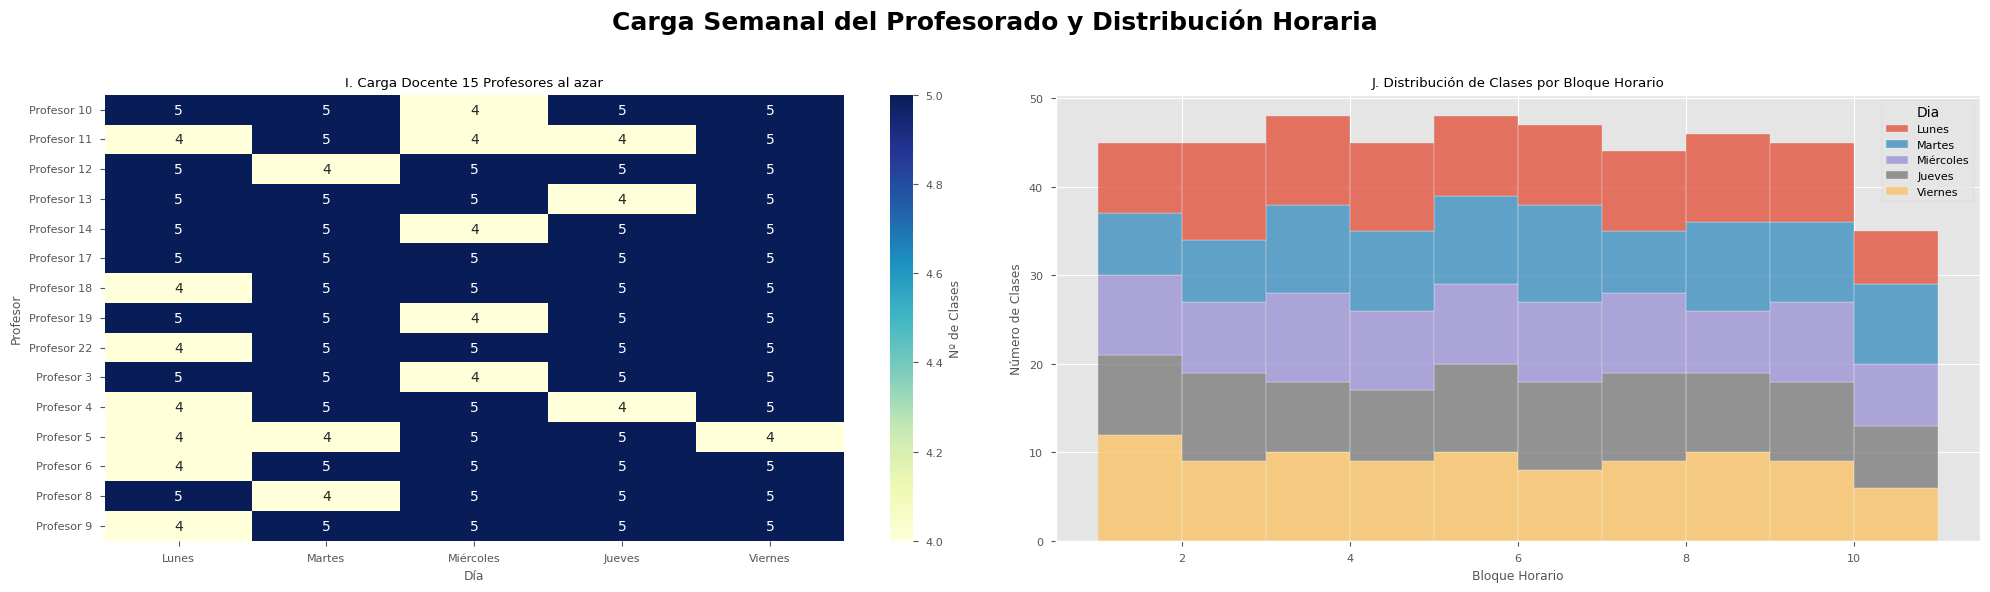

In [ ]:
# =========================================================
# 3. MÉTRICAS DERIVADAS PARA RESTRICCIONES BLANDAS
# =========================================================

# Aulas con overbooking y con infrautilización
df_metrics['Overbooking']    = df_metrics['Saturacion'] > 100
df_metrics['Infrautilizada'] = df_metrics['Saturacion'] < 50

# Definimos franjas "tardías" (ajusta el umbral a tu gusto)
df_metrics['EsTarde'] = df_metrics['Hora'] >= 6  # p.ej. a partir del 6º bloque

# Carga diaria por profesor (nº de clases día)
prof_day_load = (
    df_metrics
    .groupby(['Profesor', 'Dia'])
    .size()
    .reset_index(name='NumClases')
)

# Carga total por profesor para seleccionar top
prof_total_load = prof_day_load.groupby('Profesor')['NumClases'].sum().sort_values(ascending=False)
top_profes = prof_total_load.head(15).index  # top 15 para no explotar el heatmap
prof_day_top = prof_day_load[prof_day_load['Profesor'].isin(top_profes)]

# Pivot de carga profesor-día
pivot_prof_dia = prof_day_top.pivot_table(
    index='Profesor', columns='Dia', values='NumClases', aggfunc='sum', fill_value=0
)

# Resumen overbooking / infrautilización por día
soft_by_day = df_metrics.groupby('Dia').agg(
    Overbooking=('Overbooking', 'sum'),
    Infrautilizada=('Infrautilizada', 'sum'),
    Media_Saturacion=('Saturacion', 'mean')
).reset_index()

# Uso tarde por día
tarde_by_day = df_metrics.groupby('Dia').agg(
    ClasesTarde=('EsTarde', 'sum'),
    TotalClases=('TaskID', 'count')
)
tarde_by_day['PorcTarde'] = 100 * tarde_by_day['ClasesTarde'] / tarde_by_day['TotalClases']

# =========================================================
# 5. FIGURA 3: CARGA DOCENTE Y COMPACIDAD (HEATMAP + HIST)
# =========================================================
fig3, (cx1, cx2) = plt.subplots(1, 2, figsize=(20, 6))
fig3.suptitle('Carga Semanal del Profesorado y Distribución Horaria', 
              fontsize=18, weight='bold')

# --- C1: Heatmap Carga Profesor-Día (Top 15) ---
sns.heatmap(
    pivot_prof_dia,
    annot=True, fmt='d',
    cmap='YlGnBu',
    cbar_kws={'label': 'Nº de Clases'},
    ax=cx1
)
cx1.set_title("I. Carga Docente 15 Profesores al azar")
cx1.set_xlabel("Día")
cx1.set_ylabel("Profesor")

# --- C2: Histograma de Distribución Horaria ---
sns.histplot(
    data=df_metrics,
    x='Hora',
    bins=range(int(df_metrics['Hora'].min()), int(df_metrics['Hora'].max()) + 2),
    hue='Dia',
    multiple='stack',
    ax=cx2
)
cx2.set_title("J. Distribución de Clases por Bloque Horario")
cx2.set_xlabel("Bloque Horario")
cx2.set_ylabel("Número de Clases")

plt.tight_layout(rect=[0, 0, 1, 0.96])


In [13]:
from src.graficar_horarios import plot_horario_interactivo

dias_map = {0: "Lunes", 1: "Martes", 2: "Miércoles", 3: "Jueves", 4: "Viernes"}
data_list = []

# Copia de seguridad del DF de tareas para búsquedas (índice string para evitar errores)
df_tareas = datos_ga['tasks_df'].copy()
df_tareas.index = df_tareas.index.astype(str)

for t_id, val in current_sol.items():
    # Detectar estructura (ACO vs GA)
    try:
        if len(val) == 3: # Estructura (Prof, (Dia, Hora), Aula)
            prof = val[0]
            dia_num, hora_num = val[1]
            aula = val[2]
        elif len(val) == 4: # Estructura [Prof, Aula, Dia, Hora]
            prof, aula, dia_num, hora_num = val
        else:
            continue
    except:
        continue

    # Recuperar metadatos
    t_id_str = str(t_id)
    if t_id_str in df_tareas.index:
        meta = df_tareas.loc[t_id_str]
        
        # Convertir a tipos nativos de Python para evitar problemas de serialización
        d_int = int(dia_num)
        h_int = int(hora_num)
        
        if 0 <= d_int < 5:
            data_list.append({
                "Grupo": meta['group'],
                "Asignatura": meta['subject'],
                "Profesor": prof,
                "Aula": aula,
                "Día": dias_map[d_int],
                "Hora": h_int + 1 # 1-based para visualización
            })

# --- 3. EJECUTAR ---
df_plot = pd.DataFrame(data_list)
plot_horario_interactivo(df_plot, filename="horario_final.html")

ValueError: invalid literal for int() with base 10: 'Jueves'